# LL Transport

Compute transport properties. Details of computation are discussed in the supplemental material.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dgutils import colors as col
import dgutils
from scipy.optimize import fsolve
from collections import defaultdict

import matplotlib.patheffects as path_effects

from numpy import pi as π
from scipy import integrate
from scipy.constants import hbar as ħ
from scipy.constants import k as kB
from scipy.special import ellipe
from scipy.special import ellipk
import numpy.ma as ma
import os

import heprops

# Notebook display options
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle', 
              'sans':'../include/sans.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])

figsize = plt.rcParams['figure.figsize']

π = np.pi

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
grey = '#4B4B4B'
Kcolors = [colors[0],colors[1],colors[-2],'#74c7a5']

## Generate Velocity vs. Temperature

We need to solve the equation:

\begin{equation}
\frac{T_{\Delta P}}{T_L} \left(\frac{T_L}{T}\right)^{2/K-1} \frac{1}{N_{\rm imp}y_1^2} - \frac{T_L v_s}{T v} \Phi\left(\frac{T_L v_s}{T v}\right) = 0
\end{equation}

where the scaling function is:

\begin{equation}
\Phi(z) =  {2 (2 \pi)^{2/K} \over z} \sin\left({\pi \over K}\right) {\rm Im} \left[ {\Gamma\left({1 \over K} - i z \right) \over \Gamma \left(1 - {1 \over K} - i  z\right)}\right]  
\Gamma\left(1 - {2 \over K}\right)
\end{equation}

and we have introduced a new temperature and velocity scale:

\begin{equation}
k_{\rm B} T_{\Delta P} \equiv \frac{\Delta P}{\rho_s^{3D}} \quad \quad \hbar v_{\Delta P} \equiv \frac{k_{\rm B} T_{\Delta P}}{\rho_0}
\end{equation}

with $\rho_s^{3D}$ the 3D superfluid number density and $k_{\rm B}T_L = \hbar v \rho_0$ where $\rho_0$ is the 1D density of the core.

Thus, for fixed $T$ and $\Delta P$ we can numerically $v_s/v$.

<!--
\begin{equation}
v_s(T)  =  {v_0 \over  y_1^2 N_{\rm imp}} \, 
{\sec\left({\pi \over K}\right)  \over   \pi^{5\over 2}   \Gamma \left( {1 \over 2} - {1 \over K}\right)\Gamma \left( {1 \over K}\right)}
\left( {\pi T a \over v}\right)^{2 - {2 \over K}} \ \ .
\end{equation} -->

In [3]:
from scipy.special import gamma as Γ

def zΦ(z,K):
    return 2*(2*π)**(2.0/K)*np.sin(π/K)*Γ(1.0-2.0/K)*np.imag(Γ(1/K-z*1j)/Γ(1-1/K-z*1j))

def eqn(z,T,Tₗ,Tₚ,Nimp,y1,K):
    return (Tₚ/Tₗ)*(Tₗ/T)**(2.0/K-1)*(1/(Nimp*y1*y1)) - zΦ(z,K)

def LHS(T,Tₗ,Tₚ,Nimp,y1,K):
    return (Tₚ/Tₗ)*(Tₗ/T)**(2.0/K-1)*(1/(Nimp*y1*y1))

def TΔP(ΔP,T):
    ''' T^*
    This is a bit tricky because of the temperature dependence of the density.  We use `heprops`. '''
    m = heprops.helium.const['mass']
    ΔP_Pa = heprops.helium.convert_P(np.copy(ΔP),'bar','Pa')
    ρs = heprops.helium.density(T, ΔP_Pa)
    return  ΔP_Pa * m / ρs / kB

# labelling routines used for the data dictionaries
def Klab(K):
    return f'K = {K:2.1f}'

def Plab(ΔP):
    return f'ΔP = {ΔP:2.1f} bar'

def Tlab(_T):
    return f'T = {_T:5.3f} K'

def Nimplab(_N):
    return f'Nimp = {_N:3d}'

## Solve the equation above numerically

In [4]:
%%time
Tₗ = 10.5
Nimp = 20
y1 = 0.02
K = 1.3
ρ0 = 0.25

T = np.linspace(0.0005,1.0,5000) # in K
P = np.linspace(0.1,1.5,15) # in atm

z_sol = defaultdict(list)
for cP in P:
    for cT in T: 
        Tₚ = TΔP(cP,cT)
        z_sol[Plab(cP)].append(fsolve(eqn, 0.0,args=(cT,Tₗ,Tₚ,Nimp,y1,K))[0])
    z_sol[Plab(cP)] = np.array(z_sol[Plab(cP)])

CPU times: user 1min 3s, sys: 58.3 ms, total: 1min 3s
Wall time: 1min 4s


### We also want to compute this for a few differen't values of Nimp at fixed P = 1 bar

In [5]:
%%time
z_solNimp = defaultdict(list)
cP = 0.2
Nimps = [15,20,40,100]

for cNimp in Nimps:
    for cT in T: 
        Tₚ = TΔP(cP,cT)
        z_solNimp[Nimplab(cNimp)].append(fsolve(eqn, 1E-8,args=(cT,Tₗ,Tₚ,cNimp,y1,K))[0])
    z_solNimp[Nimplab(cNimp)] = np.array(z_solNimp[Nimplab(cNimp)])

<timed exec>:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


CPU times: user 18.5 s, sys: 8.68 ms, total: 18.5 s
Wall time: 18.6 s


## Plot the results at fixed $K$ for different pressure differences

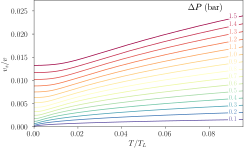

In [6]:
Pcolors = col.get_linear_colors('Spectral_r',len(P))
path_eff = [path_effects.withSimplePatchShadow(offset=(0.02, -0.02), shadow_rgbFace='k', alpha=0.5)]

outline_effect = [path_effects.Stroke(linewidth=2, foreground='white'),
                  path_effects.Normal()]

bbox_props = dict(boxstyle='round,pad=0', facecolor='white', edgecolor='none', alpha=1.0)


plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    shift = -100
    
    for iP,cP in enumerate(P):
        Tₚ = TΔP(cP,cT)
        plt.plot((T/Tₗ),(T/Tₗ)*z_sol[Plab(cP)], color=Pcolors[iP], label=Plab(cP))
        
        # method 1, labels after curves
        #ax.text(T[-1]/Tₗ+0.005,(T[-1]/Tₗ)*z_sol[Plab(cP)][-1],f'{cP:2.1f}', ha='left',va='center', color=Pcolors[iP],
        #                      fontsize=9, path_effects=path_eff)

        # method 2, labels inside curves
        tx = ax.text(T[shift]/Tₗ,(T[shift]/Tₗ)*z_sol[Plab(cP)][shift]+0.0001,f'{cP:2.1f}', ha='right',va='center', color=Pcolors[iP],
                              fontsize=7, path_effects=outline_effect)

        tx.set_bbox(bbox_props)

    ax.set_xlabel(r'$T/T_L$')
    ax.set_ylabel(r'$v_s/v$')

    # method 1
    x_shift = 0.0015

    # method2
    x_shift = -0.0145
    ax.text(T[shift]/Tₗ+x_shift,(T[shift]/Tₗ)*z_sol[Plab(1.5)][shift]+0.001,r'$\Delta P$'+' (bar)', ha='center',va='bottom', color='k',
                              fontsize=9, path_effects=path_eff)

    # method 1
    #ax.set_xlim(0,0.21)

    # method 2
    ax.set_xlim(0,T[-1]/Tₗ)

    ymax = 1.14*(T[-1]/Tₗ)*z_sol[Plab(cP)][-1]
    ax.set_ylim(0,ymax)
    plt.savefig('../figures/vsov_vs_ToTL_varP.pdf')

## We make the identical plot in physical SI units

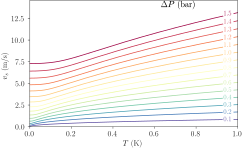

In [7]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    shift = -100
    
    for iP,cP in enumerate(P):
        Tₚ = TΔP(cP,cT)
        plt.plot(T,(T/Tₗ)*z_sol[Plab(cP)]*550, color=Pcolors[iP], label=Plab(cP))
        
        # method 2, labels inside curves
        tx = ax.text(T[shift],(T[shift]/Tₗ)*z_sol[Plab(cP)][shift]*550+0.0001,f'{cP:2.1f}', ha='right',va='center', color=Pcolors[iP],
                              fontsize=7, path_effects=outline_effect)

        tx.set_bbox(bbox_props)

    ax.set_xlabel(r'$T$' + ' (K)')
    ax.set_ylabel(r'$v_s$'+ ' (m/s)')
    
    x_shift = -0.35
    ax.text(T[shift]+x_shift,(T[shift]/Tₗ)*z_sol[Plab(1.5)][shift]*550+0.5,r'$\Delta P$'+' (bar)', ha='left',va='bottom', color='k',
                              fontsize=9, path_effects=path_eff)

    # method 2
    ax.set_xlim(0,T[-1])
    ax.set_ylim(0,0.0265*550)
    plt.savefig('../figures/vs_vs_T_varP_SI.pdf')

### Plot as a function of temperature for different $N_{\rm imp}$

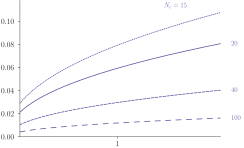

In [27]:
import matplotlib.ticker as ticker

def plot_v_vs_T_Nimp(_ax):
    Tₚ = TΔP(1.0,1.0)
    indexT = np.where(np.abs(T/Tₚ - 1.95) < T[0]/2)[0][0]

    Nimp_color = Pcolors[0]
    ls = [':','-','--',(0, (7, 7)),]
    lab_shift = [-0.62,0,0,0.00]
    lab_shift_y = [0.006,0,0,0.00]
    
    for iNimp,cNimp in enumerate(Nimps):
        _ax.plot((T/Tₚ),(T/Tₚ)*z_solNimp[Nimplab(cNimp)], color=Nimp_color, 
                 label=Nimplab(cNimp), linestyle=ls[iNimp], lw=0.75)

        if iNimp == 0:
            lab = r'$N_c = $'+f'{cNimp:3d}'
        else:
            lab = f'{cNimp:3d}'
        tx = _ax.text(1.05*T[indexT]/Tₚ+lab_shift[iNimp],(T[indexT]/Tₚ)*z_solNimp[Nimplab(cNimp)][indexT]+lab_shift_y[iNimp],
                      lab, ha='left',va='center', color=Nimp_color,fontsize=7)
        tx.set_bbox(bbox_props)
    
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.set_xlim(0.1,T[indexT]/Tₚ);
    _ax.set_ylim(0,0.118);
    _ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    # _ax.text(T[indexT]/Tₚ-0.02,(T[indexT]/Tₚ)*z_solNimp[Nimplab(20)][indexT]+0.028,r'$N_{\rm imp}$', ha='center',
    #          va='bottom', color=Nimp_color,fontsize=9, path_effects=path_eff)

    # _ax.text(T[0]/Tₚ+0.01,(T[indexT]/Tₚ)*z_solNimp[Nimplab(20)][indexT]+0.028,r'$\Delta P = P^{\ast}$', ha='left',
    #          va='bottom', color=Nimp_color,fontsize=9, path_effects=path_eff)

    return _ax

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    ax = plot_v_vs_T_Nimp(ax)

## As a final version we rescale by a fixed pressure dependent velocity and temperature scale

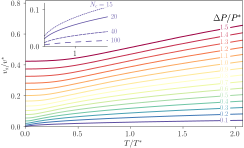

In [28]:
Tₚ = TΔP(1.0,1.0)
indexT = np.where(np.abs(T/Tₚ - 1.95) < T[0]/2)[0][0]
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    
    for iP,cP in enumerate(P):        
        plt.plot((T/Tₚ),(T/Tₚ)*z_sol[Plab(cP)], color=Pcolors[iP], label=Plab(cP), lw=1.0)

        # method 2, labels inside curves
        tx = ax.text(T[indexT]/Tₚ,(T[indexT]/Tₚ)*z_sol[Plab(cP)][indexT]+0.0001,f'{cP:2.1f}', ha='right',va='center', color=Pcolors[iP],
                               fontsize=7)
        tx.set_bbox(bbox_props)

    ax.set_xlabel(r'$T/T^\ast$')
    ax.set_ylabel(r'$v_s/v^\ast$')

    # # method2
    ax.text(T[indexT]/Tₚ-0.02,(T[indexT]/Tₚ)*z_sol[Plab(1.5)][indexT]+0.03,r'$\Delta P/P^\ast$', ha='center',va='bottom', color='k',
                               fontsize=9, path_effects=path_eff)

    par_label = r'\begin{align*}K &= 1.3 \\'
    par_label += r'P^{\ast} &= 1~{\rm atm} \\'
    par_label += r'T^{\ast} &\simeq 0.3~{\rm K} \\' 
    par_label += r'v^{\ast} &\simeq 17~{\rm m/s} \end{align*}'
    from matplotlib import rc
    rc('text', usetex=True)
    #ax.text(0.015,0.71, par_label )

    # method 2|
    ax.set_xlim(0,1.06*T[indexT]/Tₚ)
    ax.set_ylim(0,1.27*(T[indexT]/Tₚ)*z_sol[Plab(cP)][indexT])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

    # add an inset showing Nimp dependence

    ax_inset = ax.inset_axes([0.18, 0.52, 0.6, 0.28], transform=ax.transData)  # [x, y, width, height] in axes coordinates
    plot_v_vs_T_Nimp(ax_inset)
    
    plt.savefig('../figures/vsovstar_vs_ToTstar_varP_inset.pdf')
    plt.savefig('../figures/vsovstar_vs_ToTstar_varP_inset.svg')

## Extract the solution at isotherms as a function of pressure

In [10]:
z_solT = defaultdict(list)
Texp = np.array([0.01, 0.025, 0.1, TΔP(1.0,1.0), 2*TΔP(1.0,1.0)])
for cT in Texp:
    indexT = np.where(np.abs(cT-T)<0.5*T[0])[0][0]

    for iP,cP in enumerate(P):
        z_solT[Tlab(cT)].append(z_sol[Plab(cP)][indexT])

    z_solT[Tlab(cT)] = np.array(z_solT[Tlab(cT)])

## Plot the result for as a function of pressure

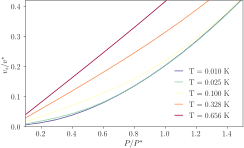

In [13]:
Tcolors = col.get_linear_colors('Spectral_r',len(Texp))

Tₚ = TΔP(1.0,1.0)
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    shift = -3
    for iT,cT in enumerate(Texp):
        #print(P,(cT/Tₚ), z_solT[Tlab(cT)])
        plt.plot(P,(cT/Tₚ)*z_solT[Tlab(cT)], color=Tcolors[iT], label=Tlab(cT))
        
        # method 1, labels after curves
        #ax.text(T[-1]/Tₗ+0.005,(T[-1]/Tₗ)*z_sol[Plab(cP)][-1],f'{cP:2.1f}', ha='left',va='center', color=Pcolors[iP],
        #                      fontsize=9, path_effects=path_eff)

        # method 2, labels inside curves
        # tx = ax.text(T[shift]/Tₗ,(T[shift]/Tₗ)*z_sol[Plab(cP)][shift]+0.0001,f'{cP:2.1f}', ha='right',va='center', color=Pcolors[iP],
        #                       fontsize=7, path_effects=outline_effect)

        # tx.set_bbox(bbox_props)

    ax.set_xlabel(r'$P/P^\ast$')
    ax.set_ylabel(r'$v_s/v^\ast$')

    # # method 1
    # x_shift = 0.0015

    # # method2
    # x_shift = -0.0145
    # ax.text(T[shift]/Tₗ+x_shift,(T[shift]/Tₗ)*z_sol[Plab(1.5)][shift]+0.0015,r'$\Delta P$'+' (bar)', ha='center',va='bottom', color='k',
    #                           fontsize=9, path_effects=path_eff)

    # method 1
    #ax.set_xlim(0,0.21)

    # method 2
    ax.set_xlim(0.1,1.5)
    ax.set_ylim(0,0.42)
    ax.legend()
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #plt.savefig('../figures/vsovp_vs_ToTp_varP.pdf')

## Checking some scales etc.

In [14]:
Tₚ = TΔP(1.0,1.0)

In [15]:
Tₚ

0.3280442271955164

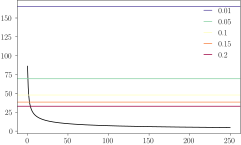

In [18]:
z = np.linspace(0.0001,250,1000)
T = [0.01,0.05,0.1,0.15,0.2]
Tcolors = col.get_linear_colors('Spectral_r',len(T)) 

plt.plot(z,zΦ(z,1.3)/z, color='k')
for iT,cT in enumerate(T):
    plt.axhline(y=LHS(cT,Tₗ,Tₚ,Nimp,y1,K),color=Tcolors[iT], label=cT)
plt.legend()

## Estimate of Experimental Scales

The relevant velocity scale is: $v_0 = {k_B T_\lambda/2 \rho_0}$ and for the unperturbed nanpores we know:

$K \simeq 1.3$, $v = 42 \mathrm{Å K}$, $\rho_0 \simeq 0.25 \mathrm{Å}^{-1}$



In [3]:
K = 1.3
v = 42
a = 1./0.25

### Relevant Temperature and Velocity Scales

In [43]:
v/a # temperature scale

10.5

In [196]:
(k/ħ)*2.1/2/(0.25E10) # velocity scale

54.98654243333537

In [194]:
0.004*10*1000

40.0

In [5]:
import heprops

In [7]:
heprops.helium.xi(0)

3.45e-10

In [11]:
heprops.helium.const['mass']

6.64647641e-27

In [9]:
from scipy.constants import h

In [12]:
h/(4*π*heprops.helium.xi(0)*heprops.helium.const['mass'])

22.99511589044174

In [29]:
P = 2.0*k*heprops.helium.density_SVP(2)/heprops.helium.const['mass']

In [30]:
heprops.helium.convert_P(P,'Pa','atm')

5.97078310129535

In [20]:
heprops.helium.density(2.0,heprops.helium.pressure_SVP(2.0))/heprops.helium.const['mass']*1E-30

0.021909609094663142

In [26]:
heprops.helium.density_SVP(2)

array(145.6217)

In [21]:
heprops.helium.const['mass']

6.64647641e-27

### Temperature Scale

In [32]:
heprops.helium.convert_P(1000,'mbar','Pa')*heprops.helium.const['mass'] / heprops.helium.density_SVP(2) / k

0.33058419640194325

### Velocity Scale

In [7]:
k*(0.33058419640194325)/ħ/(0.25E10)

17.31207804118622

In [3]:
k/ħ/1E10*42

549.8654243333538

In [6]:
heprops.helium.density_SVP(2)

array(145.6217)